In [1]:
import torch
from matplotlib import pyplot as plt
import numpy as np
from torch import nn
import torch.nn.functional as F
from models.networks.Attention_unet import *
from models.networks.CNNVit import *
from datasets.cd_dataset import SequenceDataset
from transforms.augmentations import *
import glob
import os
from torch.utils.data import DataLoader
import json
from train.metrics import *

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
with open('logs/training_history_attention_unet.json', 'r') as f:
    history = json.load(f)

with open('logs/training_history_cnnvit.json', 'r') as f:
    history_2 = json.load(f)

In [4]:
# Extract data of log history of Attention Unet
train_loss = history['train_loss']
val_loss = history['val_loss']

# Extract data of log history of CNNVit
train_loss_2 = history_2['train_loss']
val_loss_2 = history_2['val_loss']

Performance of the networks during training

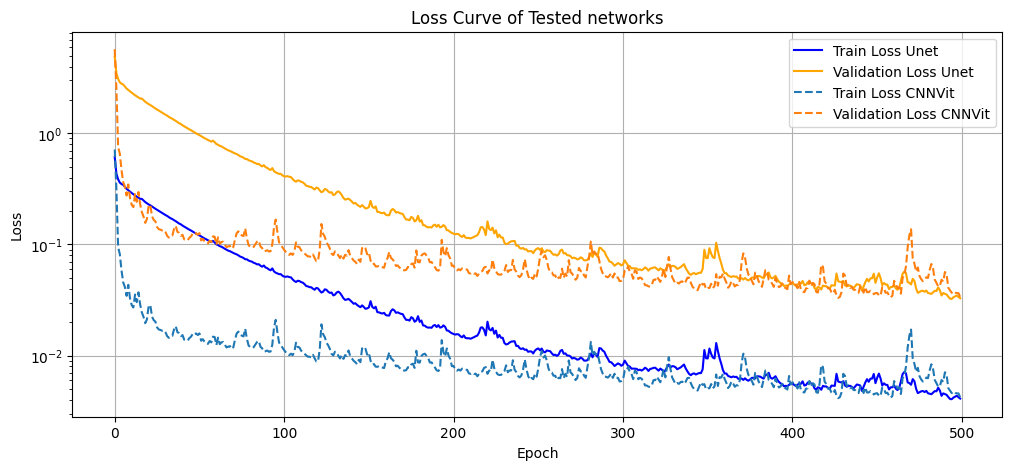

In [5]:
plt.figure(figsize=(12, 5))
plt.semilogy(train_loss, label='Train Loss Unet', color='blue')
plt.semilogy(val_loss, label='Validation Loss Unet', color='orange')
plt.semilogy(train_loss_2, label='Train Loss CNNVit',linestyle='--')
plt.semilogy(val_loss_2, label='Validation Loss CNNVit',linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve of Tested networks')
plt.legend()
plt.grid(True)

In [6]:
# Loading data for the inference
with open('splits/splits.json', 'r') as f:
    splits = json.load(f)


test_images = splits['test']['images']
test_labels = splits['test']['labels']

In [7]:
transform_test=Compose3D([NormalizeTo01()])

test_dataset = SequenceDataset(test_images, test_labels, crop=True,target_size=(256,256),limit_sequence=True,transform=transform_test,allowed_length=45)
loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [8]:
images_1, labels_1 = next(iter(loader))

Example of input and label mask for our networks

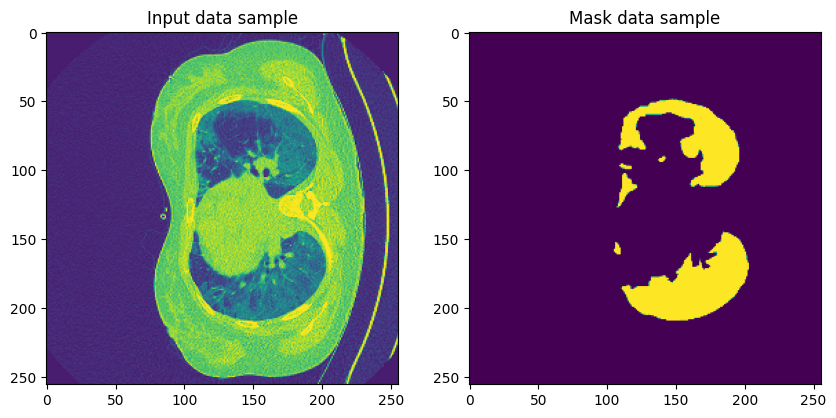

In [9]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Input data sample')
plt.imshow(images_1[0,0,:,:,-1])

plt.subplot(1,2,2)
plt.title('Mask data sample')
plt.imshow(labels_1[0,0,:,:,-1])

In [10]:
images_1=images_1.to(device)
labels_1=labels_1.to(device)

In [3]:
model = AttentionUnet(n_classes=1, in_channels=1).to(device)
checkpoints_path='/home/jaworskj/Desktop/Foundaition_thermography/Attention_unet/checkpoints_unet/model_unet_epoch_500.pth'
model.load_state_dict(torch.load(checkpoints_path,map_location=device))
model.eval()

AttentionUnet(
  (convdown1): DownBlock(
    (convblock): ConvBlock(
      (block): Sequential(
        (0): Conv3d(1, 64, kernel_size=(3, 3, 1), stride=(1, 1, 1), padding=(1, 1, 0))
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv3d(64, 64, kernel_size=(3, 3, 1), stride=(1, 1, 1), padding=(1, 1, 0))
        (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (maxpool): MaxPool3d(kernel_size=(2, 2, 1), stride=(2, 2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (convdown2): DownBlock(
    (convblock): ConvBlock(
      (block): Sequential(
        (0): Conv3d(64, 128, kernel_size=(3, 3, 1), stride=(1, 1, 1), padding=(1, 1, 0))
        (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv3d(128, 128, kernel_size=(3, 3, 1), stride

In [4]:
model_2=CNNVit(in_channels=1,embedding_dim=256).to(device)
checkpoints_path_2='/home/jaworskj/Desktop/Foundaition_thermography/Attention_unet/checkpoints_cnn_vit/model_cnnvit_epoch_500.pth'
model_2.load_state_dict(torch.load(checkpoints_path_2,map_location=device),strict=False)
model_2.eval()

CNNVit(
  (encoder): FeatureExtractor(
    (down1): DownBlock(
      (convblock): ConvBlock(
        (block): Sequential(
          (0): Conv3d(1, 64, kernel_size=(3, 3, 1), stride=(1, 1, 1), padding=(1, 1, 0))
          (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv3d(64, 64, kernel_size=(3, 3, 1), stride=(1, 1, 1), padding=(1, 1, 0))
          (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
        )
      )
      (maxpool): MaxPool3d(kernel_size=(2, 2, 1), stride=(2, 2, 1), padding=0, dilation=1, ceil_mode=False)
    )
    (down2): DownBlock(
      (convblock): ConvBlock(
        (block): Sequential(
          (0): Conv3d(64, 128, kernel_size=(3, 3, 1), stride=(1, 1, 1), padding=(1, 1, 0))
          (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
     

Qualitative comparison of the models prediction

In [13]:
# Forward pass
with torch.no_grad():  # no need to track gradients for testing
    output, att4, att3, att2 = model(images_1)
    output2=model_2(images_1)



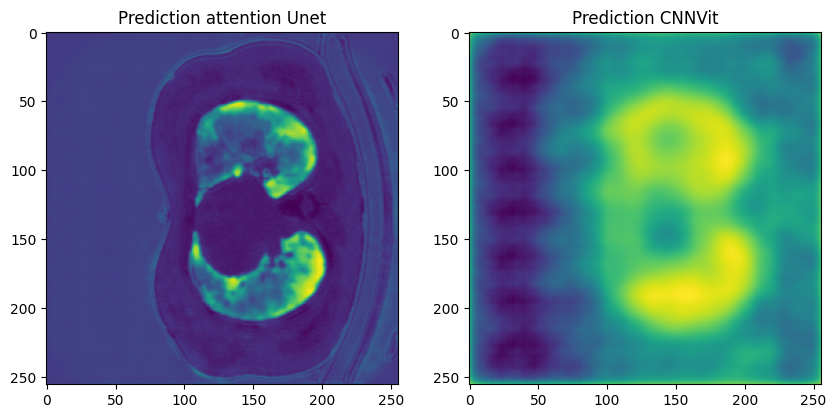

In [14]:
output=output.to(device='cpu')
output2=output2.to(device='cpu')
labels_1=labels_1.to(device='cpu')

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Prediction attention Unet')
plt.imshow(output[0,0,:,:,-1])

plt.subplot(1,2,2)
plt.title('Prediction CNNVit')
plt.imshow(output2[0,0,:,:,-1])


In [15]:
binary_output=(torch.sigmoid(output)>0.003).float()
binary_output2=(torch.sigmoid(output2)>0.1).float()

Text(0.5, 1.0, 'Ground truth')

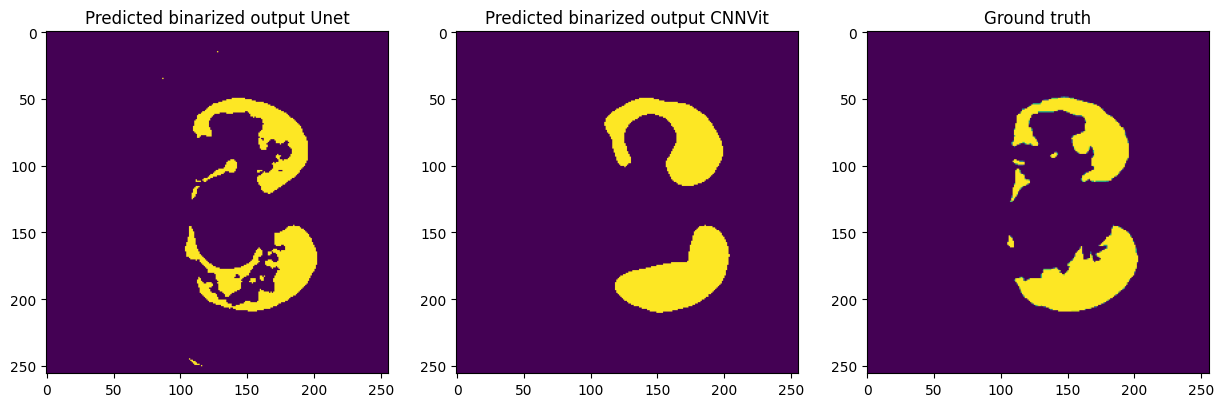

In [16]:
plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
plt.imshow(binary_output[0,0,:,:,-1])
plt.title('Predicted binarized output Unet')
plt.subplot(1,3,2)
plt.imshow(binary_output2[0,0,:,:,-1])
plt.title('Predicted binarized output CNNVit')
plt.subplot(1,3,3)
plt.imshow(labels_1[0,0,:,:,-1])
plt.title('Ground truth')



Text(0.5, 1.0, 'Ground truth')

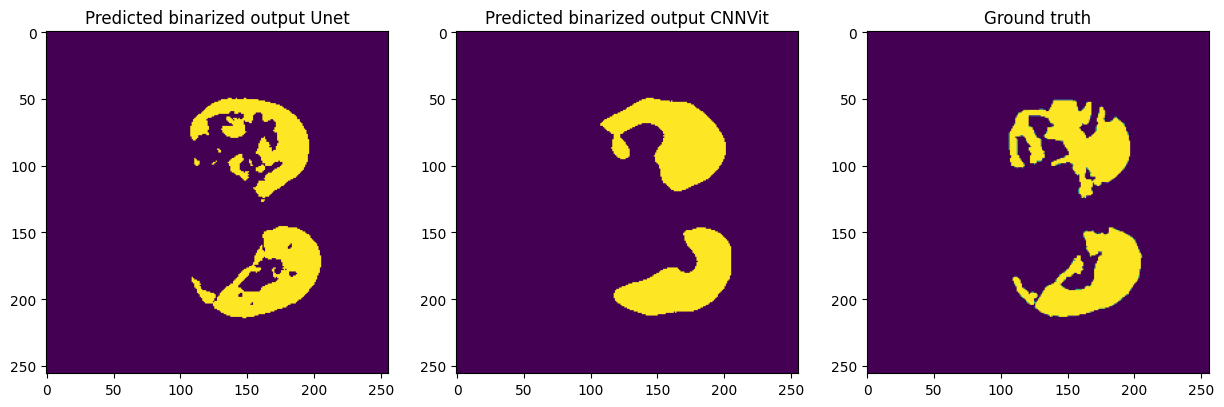

In [17]:
plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
plt.imshow(binary_output[0,0,:,:,30])
plt.title('Predicted binarized output Unet')
plt.subplot(1,3,2)
plt.imshow(binary_output2[0,0,:,:,30])
plt.title('Predicted binarized output CNNVit')
plt.subplot(1,3,3)
plt.imshow(labels_1[0,0,:,:,30])
plt.title('Ground truth')

Attention map for the Attention Unet

In [18]:
att2=att2.to(device='cpu')
att3=att3.to(device='cpu')
att4=att4.to(device='cpu')

Text(0.5, 1.0, 'Deepest attention map')

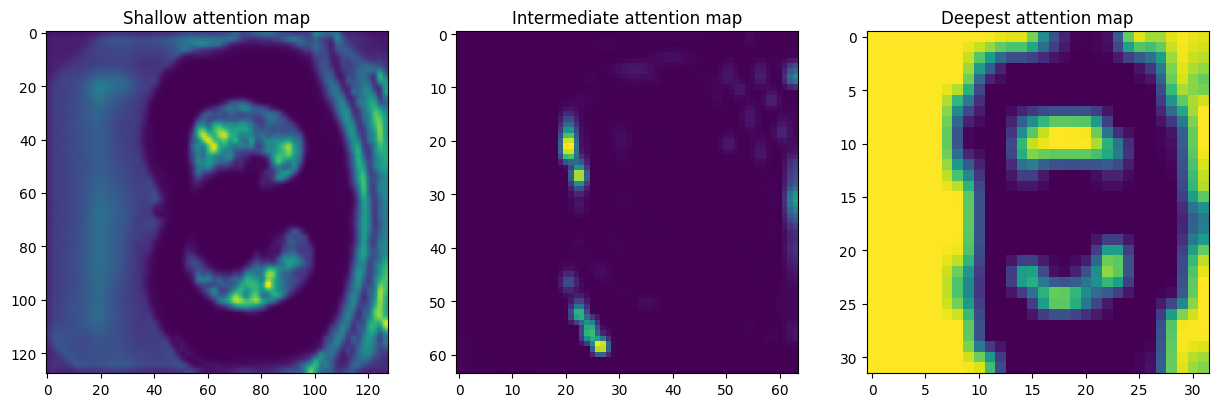

In [19]:
plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
plt.imshow(att2[0,0,:,:,-1])
plt.title('Shallow attention map')
plt.subplot(1,3,2)
plt.imshow(att3[0,0,:,:,-1])
plt.title('Intermediate attention map')
plt.subplot(1,3,3)
plt.imshow(att4[0,0,:,:,-1])
plt.title('Deepest attention map')

Text(0.5, 1.0, 'Deepest attention map')

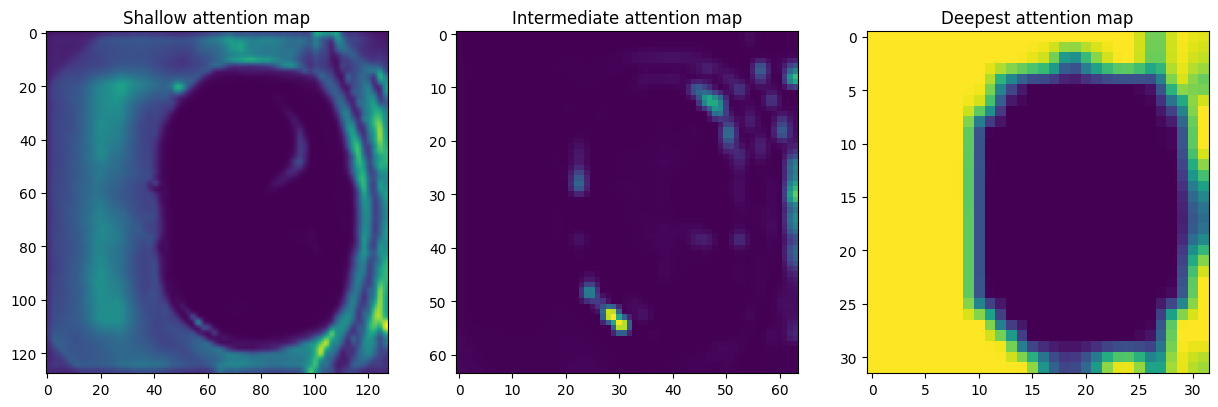

In [20]:
plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
plt.imshow(att2[0,0,:,:,15])
plt.title('Shallow attention map')
plt.subplot(1,3,2)
plt.imshow(att3[0,0,:,:,15])
plt.title('Intermediate attention map')
plt.subplot(1,3,3)
plt.imshow(att4[0,0,:,:,15])
plt.title('Deepest attention map')

Evaluation metrics between the models

In [21]:
eval=evaluation()

In [22]:
model_1_res=eval.evaluate_model(model=model,dataloader=loader,treshold=0.003,device=device,model_unet=True)

Evaluation metric of the Unet with attention

In [23]:
model_1_res

{'dice': 0.40408806630875915,
 'precision': 0.39618224691366777,
 'recall': 0.634935274720192,
 'f1': 0.4040881471009925,
 'iou': 0.33776221808511764}

In [24]:
model_2_res=eval.evaluate_model(model=model_2,dataloader=loader,treshold=0.1,device=device,model_unet=False)

Evaluation metrics of CNNVit

In [25]:
model_2_res

{'dice': 0.4071594187989831,
 'precision': 0.3886786913499236,
 'recall': 0.74420166015625,
 'f1': 0.4071595184504986,
 'iou': 0.33219646383076906}